# QEvasion – Multi-Model Transformer Comparison (v2)

This notebook extends the **v2** pipeline to test and compare multiple Transformer architectures on the QEvasion dataset.

## Objectives
1.  **Iterate through 3 Models**:
    *   `distilbert-base-uncased` (Baseline)
    *   `bert-base-uncased`
    *   `albert-base-v2`
2.  **Train Multi-Task Models**: Jointly predict Clarity (3-way) and Evasion (9-way).
3.  **Visualize Per-Model Performance**: Training curves and Confusion Matrices.
4.  **Final Comparison**: Aggregate results and plot a comparative Bar Chart.

## Setup

In [1]:
# If Colab, run this cell to clone the repo
!rm -rf political-evasion-classifier
!git clone https://github.com/minh-de-rien/political-evasion-classifier.git
%cd political-evasion-classifier
import sys
sys.path.insert(0, "/content/political-evasion-classifier")

Cloning into 'political-evasion-classifier'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 102 (delta 31), reused 91 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 4.77 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/political-evasion-classifier


In [ ]:
# If local
import os
import sys
from pathlib import Path

project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# Import src modules
from src.data import (
    load_qevasion_prepared,
    prepare_task1_data,
    prepare_task2_data,
    CLARITY_LABELS, EVASION_LABELS,
    CLARITY_TO_ID, EVASION_TO_ID,
    ID_TO_CLARITY, ID_TO_EVASION,
    build_text_column, add_label_ids, get_annotator_labels
)
from src.models import MultiTaskTransformer
from src.training import train_model, EarlyStopping, evaluate_multitask
from src.metrics import evaluate_task2_multi_annotator, plot_confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 1. Data Preparation
We load the dataset once. Tokenization happens inside the training loop as it depends on the specific tokenizer.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

Train size: 3448
Test size:  308


/tmp/ipython-input-1878252232.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], palette='viridis')
/tmp/ipython-input-1878252232.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], palette='magma')


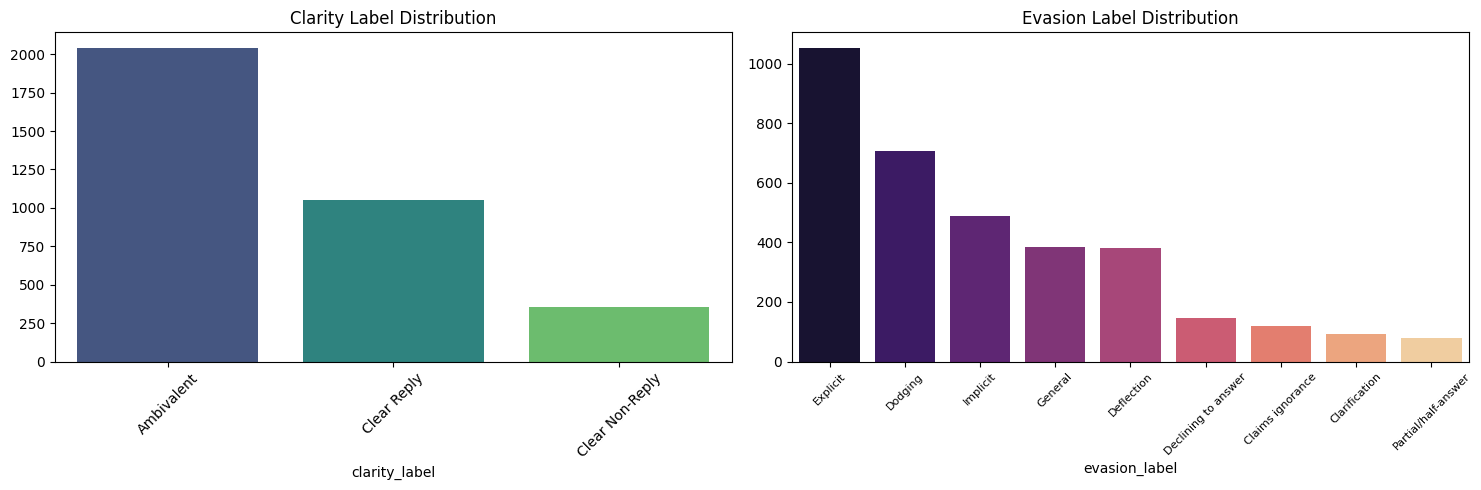

In [3]:
dataset = load_qevasion_prepared()
train_df_raw = dataset["train"].to_pandas()
test_df_raw = dataset["test"].to_pandas()

# Standard Preprocessing (Text & Labels)
# Note: In multi-task, we want rows that have at least a Clarity label.
# Evasion labels might be NaN for some (handled by mask).

def preprocess_for_multitask(df):
    df = build_text_column(df)
    df = add_label_ids(df)
    return df

train_full = preprocess_for_multitask(train_df_raw)
test_full = preprocess_for_multitask(test_df_raw)

# Add annotator labels for test set (for Evasion Acc calculation)
test_full["annotator_labels"] = test_full.apply(get_annotator_labels, axis=1)

print(f"Train size: {len(train_full)}")
print(f"Test size:  {len(test_full)}")

# Visualize Label Distribution (as requested)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

clarity_counts = train_full['clarity_label'].value_counts()
sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Clarity Label Distribution')
axes[0].tick_params(axis='x', rotation=45)

evasion_counts = train_full['evasion_label'].value_counts()
sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], palette='magma')
axes[1].set_title('Evasion Label Distribution')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

In [4]:
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text']

        enc = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'clarity_labels': torch.tensor(row['clarity_id'], dtype=torch.long)
        }

        # Handle Evasion (might be -1 if missing)
        ev_id = row['evasion_id']
        if ev_id != -1:
            item['evasion_labels'] = torch.tensor(ev_id, dtype=torch.long)
            item['evasion_mask'] = torch.tensor(1, dtype=torch.long)
        else:
            item['evasion_labels'] = torch.tensor(-1, dtype=torch.long)
            item['evasion_mask'] = torch.tensor(0, dtype=torch.long)

        return item

## 2. Experiment Configuration
We define the list of models to loop over.

In [5]:
MODELS_TO_TEST = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "albert-base-v2"
]

BATCH_SIZE = 16
MAX_LENGTH = 256
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

from sklearn.model_selection import train_test_split

# Create Train/Val split (stratified by Clarity for consistency)
train_indices, val_indices = train_test_split(
    np.arange(len(train_full)),
    test_size=0.1,
    stratify=train_full["clarity_id"].values,
    random_state=42
)

df_train = train_full.iloc[train_indices]
df_val = train_full.iloc[val_indices]
df_test = test_full

print(f"Train split: {len(df_train)}")
print(f"Val split:   {len(df_val)}")

Train split: 3103
Val split:   345


## 3. Training & Evaluation Loop


MODEL: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training distilbert-base-uncased...

Epoch 1/5
------------------------------------------------------------
Train Loss: 2.7665
Val Accuracy: 0.6087
Val Macro F1: 0.3315

Epoch 2/5
------------------------------------------------------------
Train Loss: 2.5199
Val Accuracy: 0.6464
Val Macro F1: 0.5433
Metric improved from 0.3315 to 0.5433

Epoch 3/5
------------------------------------------------------------
Train Loss: 2.1646
Val Accuracy: 0.6319
Val Macro F1: 0.5847
Metric improved from 0.5433 to 0.5847

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.8905
Val Accuracy: 0.6435
Val Macro F1: 0.6039
Metric improved from 0.5847 to 0.6039

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.6614
Val Accuracy: 0.6870
Val Macro F1: 0.6432
Metric improved from 0.6039 to 0.6432


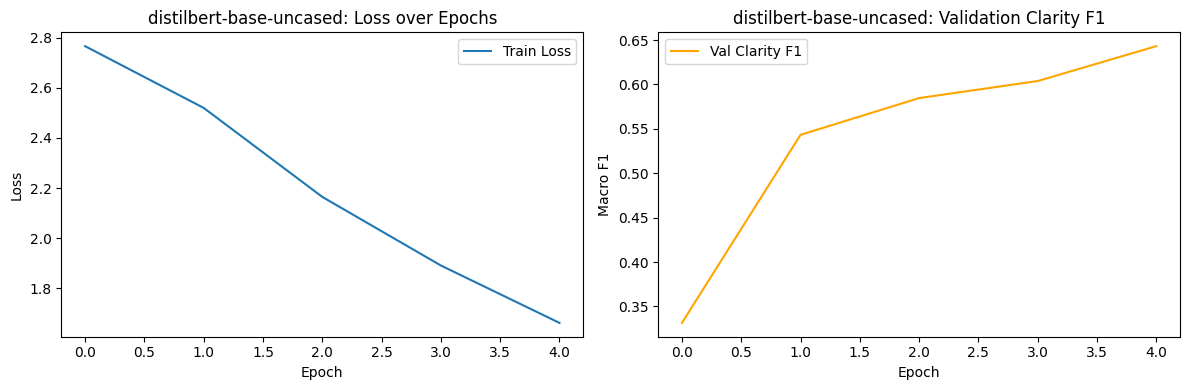

Results for distilbert-base-uncased:
  Clarity Acc: 0.6591, F1: 0.5006
  Evasion Acc (Std): 0.0000, F1 (Std): 0.0000
  Evasion Acc (Multi): 0.4318
  Total Score: 0.4662


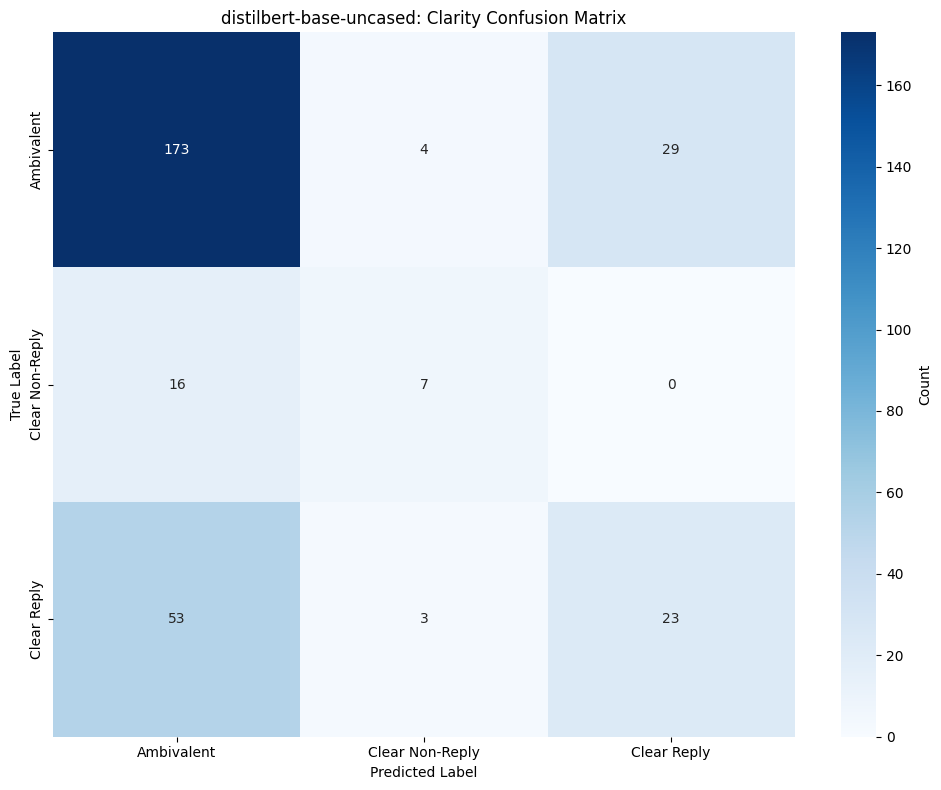


MODEL: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training bert-base-uncased...

Epoch 1/5
------------------------------------------------------------
Train Loss: 2.7204
Val Accuracy: 0.6406
Val Macro F1: 0.4688

Epoch 2/5
------------------------------------------------------------
Train Loss: 2.4068
Val Accuracy: 0.6580
Val Macro F1: 0.5893
Metric improved from 0.4688 to 0.5893

Epoch 3/5
------------------------------------------------------------
Train Loss: 2.1155
Val Accuracy: 0.6696
Val Macro F1: 0.6197
Metric improved from 0.5893 to 0.6197

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.8428
Val Accuracy: 0.6551
Val Macro F1: 0.6382
Metric improved from 0.6197 to 0.6382

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.6176
Val Accuracy: 0.6609
Val Macro F1: 0.6235
No improvement for 1 epoch(s)


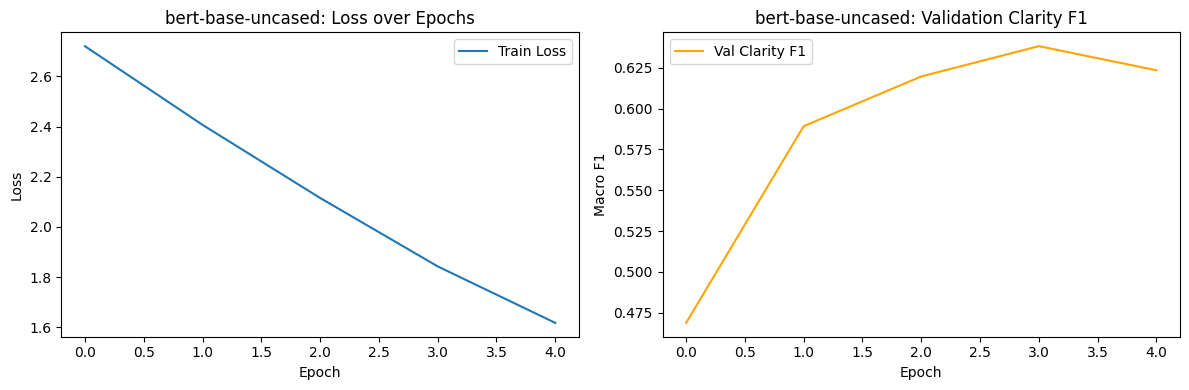

Results for bert-base-uncased:
  Clarity Acc: 0.6526, F1: 0.5363
  Evasion Acc (Std): 0.0000, F1 (Std): 0.0000
  Evasion Acc (Multi): 0.4123
  Total Score: 0.4743


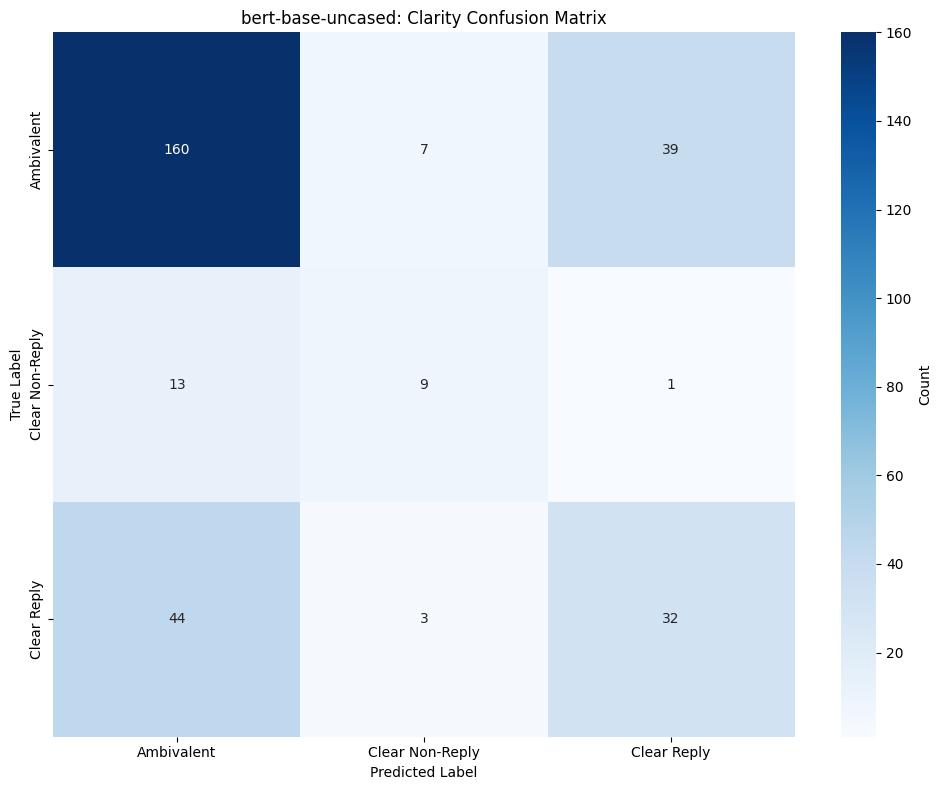


MODEL: albert-base-v2


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Training albert-base-v2...

Epoch 1/5
------------------------------------------------------------
Train Loss: 2.7825
Val Accuracy: 0.6029
Val Macro F1: 0.2740

Epoch 2/5
------------------------------------------------------------
Train Loss: 2.5192
Val Accuracy: 0.6522
Val Macro F1: 0.5333
Metric improved from 0.2740 to 0.5333

Epoch 3/5
------------------------------------------------------------
Train Loss: 2.2822
Val Accuracy: 0.6551
Val Macro F1: 0.5861
Metric improved from 0.5333 to 0.5861

Epoch 4/5
------------------------------------------------------------
Train Loss: 2.1010
Val Accuracy: 0.6696
Val Macro F1: 0.5658
No improvement for 1 epoch(s)

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.9018
Val Accuracy: 0.6493
Val Macro F1: 0.5856
No improvement for 2 epoch(s)
Early stopping triggered! Best epoch: 2

Stopping early at epoch 5


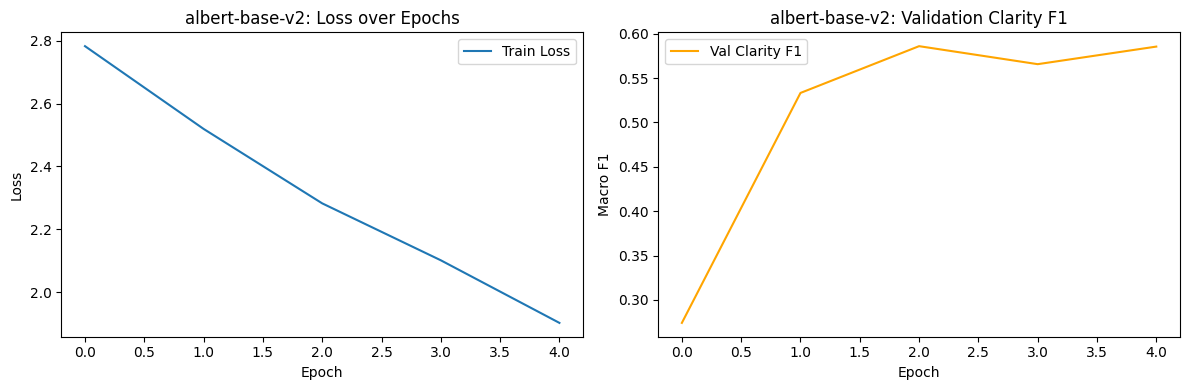

Results for albert-base-v2:
  Clarity Acc: 0.6883, F1: 0.5022
  Evasion Acc (Std): 0.0000, F1 (Std): 0.0000
  Evasion Acc (Multi): 0.4416
  Total Score: 0.4719


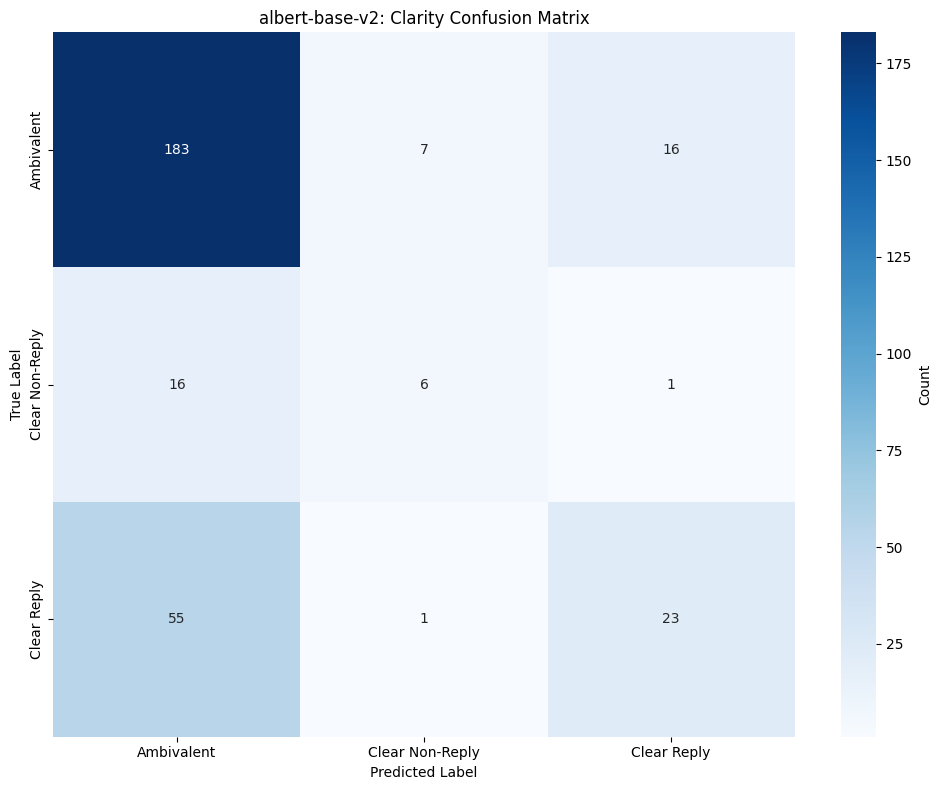

In [6]:
all_results = []

for model_name in MODELS_TO_TEST:
    print("\n" + "="*60)
    print(f"MODEL: {model_name}")
    print("="*60)

    # 1. Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # 2. DataLoaders
    train_ds = MultiTaskDataset(df_train, tokenizer, MAX_LENGTH)
    val_ds   = MultiTaskDataset(df_val, tokenizer, MAX_LENGTH)
    test_ds  = MultiTaskDataset(df_test, tokenizer, MAX_LENGTH)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

    # 3. Model Setup
    model = MultiTaskTransformer(
        model_name=model_name,
        num_clarity_labels=len(CLARITY_TO_ID),
        num_evasion_labels=len(EVASION_TO_ID)
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=2, mode='max', verbose=True)

    # 4. Training
    print(f"Training {model_name}...")
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=None,
        clarity_loss_fn=criterion,
        evasion_loss_fn=criterion,
        device=device,
        num_epochs=NUM_EPOCHS,
        early_stopping=early_stopping,
        is_multitask=True,
        verbose=True
    )

    # 5. Plot Training History
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title(f'{model_name}: Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # F1 (Clarity)
    plt.subplot(1, 2, 2)
    plt.plot(history['val_macro_f1'], label='Val Clarity F1', color='orange')
    plt.title(f'{model_name}: Validation Clarity F1')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 6. Final Evaluation on Test
    # Get Standard metrics
    test_metrics = evaluate_multitask(model, test_loader, device)

    # Get Predictions for Multi-Annotator Evasion Acc
    model.eval()
    all_ev_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            _, ev_logits = model(input_ids, mask)
            preds = torch.argmax(ev_logits, dim=-1)
            all_ev_preds.extend(preds.cpu().numpy())

    pred_labels_str = [ID_TO_EVASION[i] for i in all_ev_preds]
    gold_sets = df_test["annotator_labels"].tolist()

    # Filter to only rows that have annotators (should be all in test_df filter)
    correct_count = 0
    total_count = 0
    for pred, gold in zip(pred_labels_str, gold_sets):
        if len(gold) > 0:
            if pred in gold:
                correct_count += 1
            total_count += 1

    ev_multi_acc = correct_count / total_count if total_count > 0 else 0.0

    # Store Results (Updated with detailed metrics)
    res = {
        "Model": model_name,
        "Clarity_Acc": test_metrics.get("clarity_accuracy", 0),
        "Clarity_F1": test_metrics.get("clarity_macro_f1", 0),
        "Evasion_Acc_Std": test_metrics.get("evasion_accuracy", 0),
        "Evasion_F1_Std": test_metrics.get("evasion_macro_f1", 0),
        "Evasion_Acc_Multi": ev_multi_acc,
        "Total_Score": (test_metrics.get("clarity_macro_f1", 0) + ev_multi_acc) / 2
    }
    all_results.append(res)

    print(f"Results for {model_name}:")
    print(f"  Clarity Acc: {res['Clarity_Acc']:.4f}, F1: {res['Clarity_F1']:.4f}")
    print(f"  Evasion Acc (Std): {res['Evasion_Acc_Std']:.4f}, F1 (Std): {res['Evasion_F1_Std']:.4f}")
    print(f"  Evasion Acc (Multi): {res['Evasion_Acc_Multi']:.4f}")
    print(f"  Total Score: {res['Total_Score']:.4f}")

    # 7. Confusion Matrix (Clarity)
    # We need predictions again for Confusion Matrix
    all_cl_preds = []
    all_cl_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            cl_labels = batch["clarity_labels"]
            cl_logits, _ = model(input_ids, mask)
            preds = torch.argmax(cl_logits, dim=-1)
            all_cl_preds.extend(preds.cpu().numpy())
            all_cl_labels.extend(cl_labels.cpu().numpy())

    plot_confusion_matrix(
        np.array(all_cl_labels),
        np.array(all_cl_preds),
        label_names=CLARITY_LABELS,
        title=f"{model_name}: Clarity Confusion Matrix"
    )

    # Free memory
    del model, optimizer, train_loader, val_loader
    torch.cuda.empty_cache()

## 4. Final Comparison
Aggregating results across all tested models.


=== FINAL SUMMARY ===


,Model,Clarity_Acc,Clarity_F1,Evasion_Acc_Std,Evasion_F1_Std,Evasion_Acc_Multi,Total_Score
0,distilbert-base-uncased,0.659091,0.500615,0,0,0.431818,0.466217
1,bert-base-uncased,0.652597,0.536305,0,0,0.412338,0.474321
2,albert-base-v2,0.688312,0.502177,0,0,0.441558,0.471868


/tmp/ipython-input-401550379.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Clarity_F1", ax=axes[0], palette="Blues_d")
/tmp/ipython-input-401550379.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Clarity_Acc", ax=axes[1], palette="Purples_d")
/tmp/ipython-input-401550379.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Evasion_Acc_Multi", ax=axes[2], palette="Greens_d")
/tmp/ipython-input-401550379.py:30: FutureWarning: 

Passing `pale

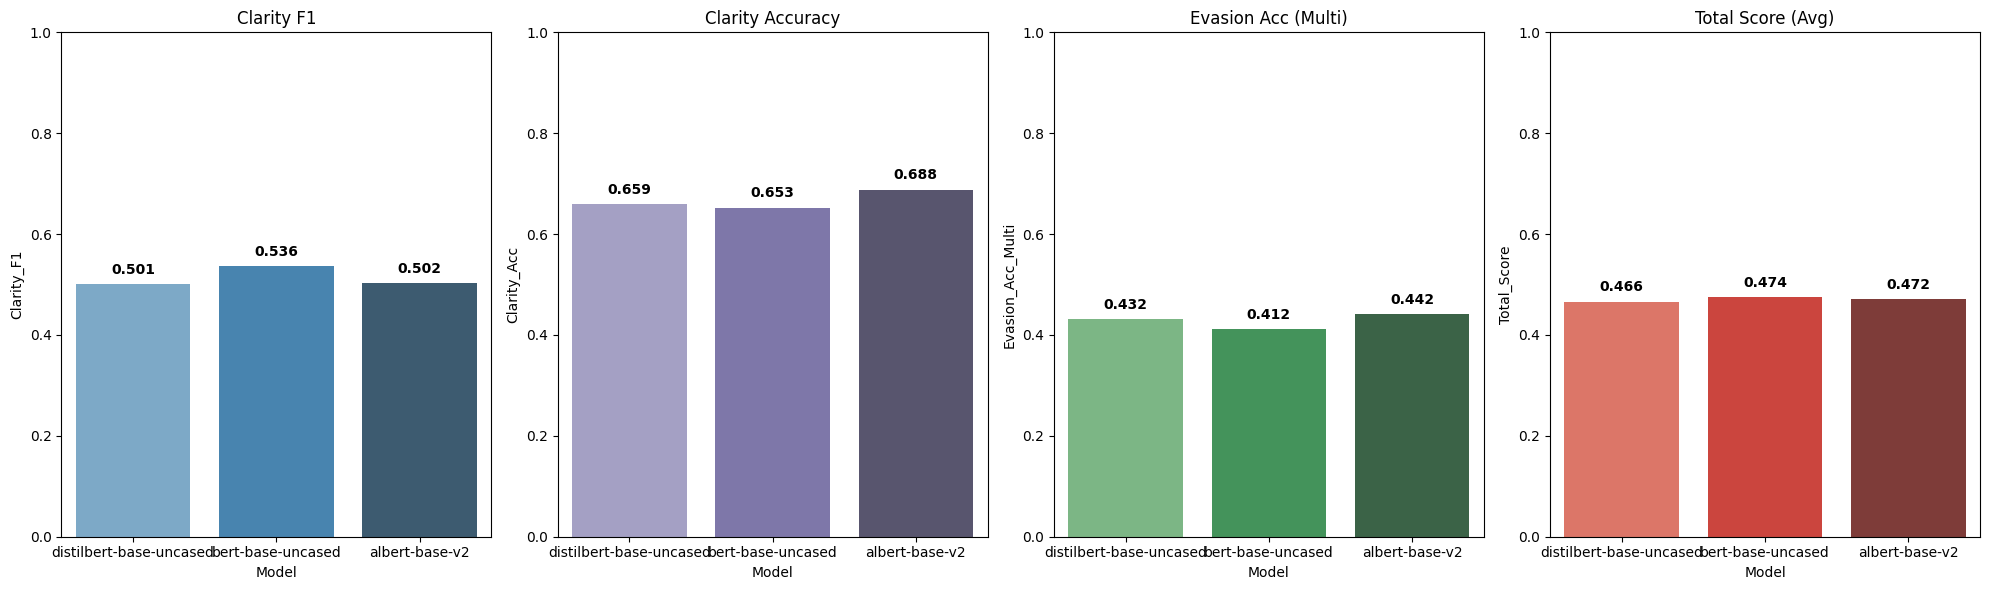

In [7]:
results_df = pd.DataFrame(all_results)
print("\n=== FINAL SUMMARY ===")
display(results_df)

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# Clarity F1 Comparison
sns.barplot(data=results_df, x="Model", y="Clarity_F1", ax=axes[0], palette="Blues_d")
axes[0].set_title("Clarity F1", fontsize=12)
axes[0].set_ylim(0, 1.0)
for i, v in enumerate(results_df["Clarity_F1"]):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

# Clarity Accuracy Comparison
sns.barplot(data=results_df, x="Model", y="Clarity_Acc", ax=axes[1], palette="Purples_d")
axes[1].set_title("Clarity Accuracy", fontsize=12)
axes[1].set_ylim(0, 1.0)
for i, v in enumerate(results_df["Clarity_Acc"]):
    axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

# Evasion Accuracy Comparison (Multi)
sns.barplot(data=results_df, x="Model", y="Evasion_Acc_Multi", ax=axes[2], palette="Greens_d")
axes[2].set_title("Evasion Acc (Multi)", fontsize=12)
axes[2].set_ylim(0, 1.0)
for i, v in enumerate(results_df["Evasion_Acc_Multi"]):
    axes[2].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

# Total Score Comparison
sns.barplot(data=results_df, x="Model", y="Total_Score", ax=axes[3], palette="Reds_d")
axes[3].set_title("Total Score (Avg)", fontsize=12)
axes[3].set_ylim(0, 1.0)
for i, v in enumerate(results_df["Total_Score"]):
    axes[3].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
results_df.to_csv("multimodel_v2_results.csv", index=False)
print("Results saved to multimodel_v2_results.csv")

Results saved to multimodel_v2_results.csv
